# House Prices - Advanced regression techniques

- author: Balázs Nagy
- e-mail: [balazs_nagy@outlook.com](balazs_nagy@outlook.com)
- date of submission: 23-02-2022

Source: https://www.kaggle.com/c/house-prices-advanced-regression-techniques

**Goal**

It is your job to predict the sales price for each house. For each Id in the test set, you must predict the value of the SalePrice variable. 

**Metric**


Submissions are evaluated on Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sales price. (Taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally.)

# Setup

In [1]:
# data manipulation
import pandas as pd
import numpy as np
from collections import Counter
from time import time

# data visualisation
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.api import qqplot

# modelling
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
#from sklearn.tree import DecisionTreeRegressor
#from sklearn.linear_model import LinearRegression, Lasso, Ridge
#from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error as MSE

In [2]:
# import both the train and the holdout test set
# combine them to a single dataframe
# mark the source with column `source`
data = pd.concat([pd.read_csv(f'data/{source}.csv').assign(source=source) for source in ['train', 'test']])

In [3]:
# making sure Id is unique so it's safe to be used as index
assert data.Id.is_unique
data.set_index('Id', inplace=True)

In [4]:
# glimpse on the data
data

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,source
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0,train
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0,train
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0,train
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0,train
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,...,NaN,NaN,NaN,0,6,2006,WD,Normal,NaN,test
2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,...,NaN,NaN,NaN,0,4,2006,WD,Abnorml,NaN,test
2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,...,NaN,NaN,NaN,0,9,2006,WD,Abnorml,NaN,test


In [5]:
data.shape

(2919, 81)

In [6]:
pd.DataFrame({'count': [sum(data.source == 'train'), sum(data.source == 'test')],
              'proportion': [sum(data.source == 'train') / len(data), sum(data.source == 'test') / len(data)]},
             index=['train', 'test'])

,count,proportion
train,1460,0.500171
test,1459,0.499829


There are $2919$ total number of observations about $50\%-50\%$ from the train and test set.

# Missing values

<AxesSubplot:>

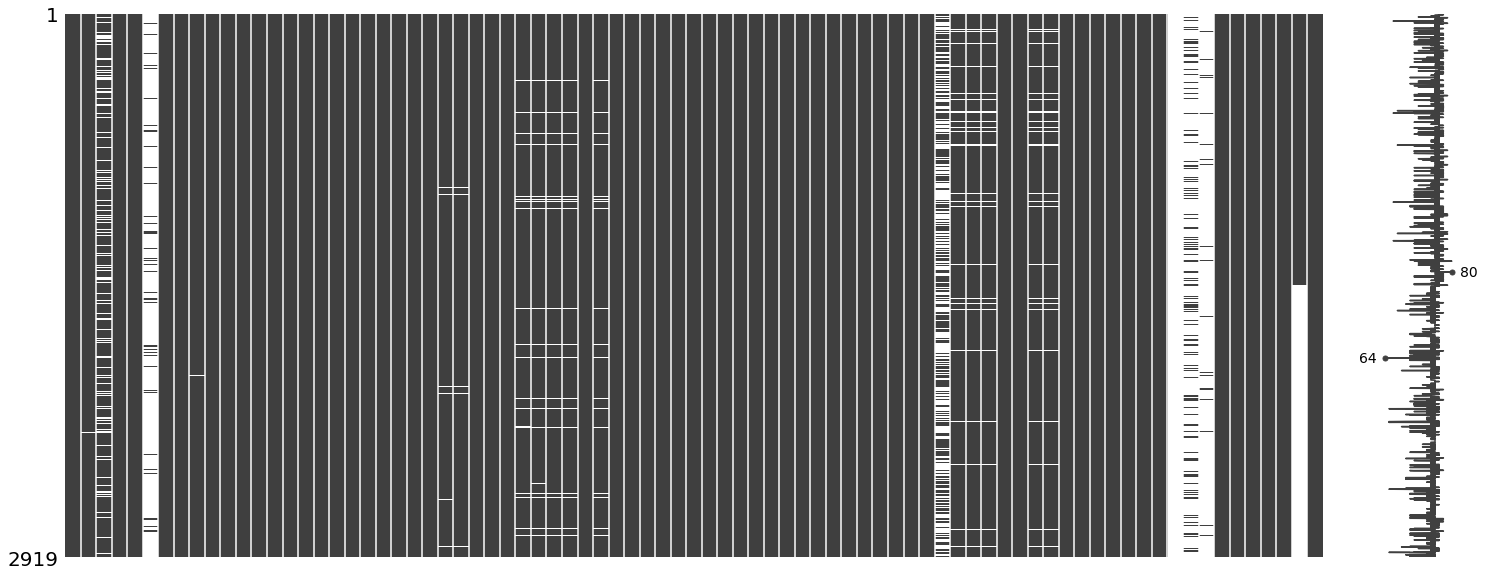

In [7]:
msno.matrix(data)

In [8]:
df_na = pd.DataFrame({'na_count': data.isna().sum().loc[data.isna().sum() > 0]})\
        .assign(na_proportion=lambda x: round(x / len(data)*100, 2))

In [9]:
df_na.na_proportion.sort_values(ascending=False)

PoolQC          99.66
MiscFeature     96.40
Alley           93.22
Fence           80.44
SalePrice       49.98
FireplaceQu     48.65
LotFrontage     16.65
GarageYrBlt      5.45
GarageFinish     5.45
GarageQual       5.45
GarageCond       5.45
GarageType       5.38
BsmtCond         2.81
BsmtExposure     2.81
BsmtQual         2.77
BsmtFinType2     2.74
BsmtFinType1     2.71
MasVnrType       0.82
MasVnrArea       0.79
MSZoning         0.14
BsmtFullBath     0.07
BsmtHalfBath     0.07
Functional       0.07
Utilities        0.07
BsmtFinSF2       0.03
BsmtUnfSF        0.03
BsmtFinSF1       0.03
TotalBsmtSF      0.03
SaleType         0.03
KitchenQual      0.03
Exterior2nd      0.03
Exterior1st      0.03
GarageCars       0.03
GarageArea       0.03
Electrical       0.03
Name: na_proportion, dtype: float64

In [10]:
df_na.na_proportion.sort_values(ascending=False).index

Index(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'SalePrice', 'FireplaceQu',
       'LotFrontage', 'GarageYrBlt', 'GarageFinish', 'GarageQual',
       'GarageCond', 'GarageType', 'BsmtCond', 'BsmtExposure', 'BsmtQual',
       'BsmtFinType2', 'BsmtFinType1', 'MasVnrType', 'MasVnrArea', 'MSZoning',
       'BsmtFullBath', 'BsmtHalfBath', 'Functional', 'Utilities', 'BsmtFinSF2',
       'BsmtUnfSF', 'BsmtFinSF1', 'TotalBsmtSF', 'SaleType', 'KitchenQual',
       'Exterior2nd', 'Exterior1st', 'GarageCars', 'GarageArea', 'Electrical'],
      dtype='object')

In [11]:
# impute with string value 'None'
cols_fillna_with_none = ['PoolQC', 'MiscFeature', 'Alley','Fence', 'FireplaceQu',
                         'GarageCond', 'GarageFinish', 'GarageQual', 'GarageType',
                         'BsmtExposure', 'BsmtCond', 'BsmtQual', 'BsmtFinType2', 'BsmtFinType1',
                         'MasVnrType'],
for col in cols_fillna_with_none:
    data[col] = data[col].fillna('None')

# impute with zero
cols_fillna_with_zero = ['GarageYrBlt', 'GarageCars', 'GarageArea',
                         'BsmtHalfBath', 'BsmtFullBath', 'BsmtFinSF2', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF',
                         'MasVnrArea']
for col in cols_fillna_with_zero:
    data[col].fillna(0, inplace=True)

# impute with most common value
cols_fillna_with_mode = ['SaleType', 'MSZoning', 'Electrical', 'Functional', 'KitchenQual', 'Utilities', 'Exterior1st', 'Exterior2nd']
for col in cols_fillna_with_mode:
    data[col].fillna(pd.Series.mode, inplace=True)

# impute LotFrontage with the median LotFrontage grouped by neighborhood
data['LotFrontage'] = data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

In [12]:
data.isna().sum()[data.isna().sum() != 0]

SalePrice    1459
dtype: int64

After the imputation there are no missing data except for the target feature `SalePrice` corresponding to the test dataset which is to be predicted.

# Data types

In [13]:
# how many unique data types
Counter(data.dtypes)

Counter({dtype('int64'): 25, dtype('O'): 44, dtype('float64'): 12})

In [14]:
# info on the dataframe - float cols
data.select_dtypes(float).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   LotFrontage   2919 non-null   float64
 1   MasVnrArea    2919 non-null   float64
 2   BsmtFinSF1    2919 non-null   float64
 3   BsmtFinSF2    2919 non-null   float64
 4   BsmtUnfSF     2919 non-null   float64
 5   TotalBsmtSF   2919 non-null   float64
 6   BsmtFullBath  2919 non-null   float64
 7   BsmtHalfBath  2919 non-null   float64
 8   GarageYrBlt   2919 non-null   float64
 9   GarageCars    2919 non-null   float64
 10  GarageArea    2919 non-null   float64
 11  SalePrice     1460 non-null   float64
dtypes: float64(12)
memory usage: 296.5 KB


We will convert floats that are in fact integers, but were either wrongly parsed during import or previously had missing values and were treated as floats.

In [15]:
cols_from_float_to_int = []
for col in data.select_dtypes(float).columns:
    if sum((data[col] % 1) != 0) == 0:
        cols_from_float_to_int.append(col)
        data[col] = data[col].astype(int)
cols_from_float_to_int

['MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'BsmtFullBath',
 'BsmtHalfBath',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea']

In [16]:
# info on the dataframe - integer cols
data.select_dtypes(int).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   MasVnrArea    2919 non-null   int32
 1   BsmtFinSF1    2919 non-null   int32
 2   BsmtFinSF2    2919 non-null   int32
 3   BsmtUnfSF     2919 non-null   int32
 4   TotalBsmtSF   2919 non-null   int32
 5   BsmtFullBath  2919 non-null   int32
 6   BsmtHalfBath  2919 non-null   int32
 7   GarageYrBlt   2919 non-null   int32
 8   GarageCars    2919 non-null   int32
 9   GarageArea    2919 non-null   int32
dtypes: int32(10)
memory usage: 136.8 KB


Convert the following columns from `int` to `object`:
- `MSSubClass`: Identifies the type of dwelling involved in the sale, so it is a categorical variable.
- `MoSold`: Month Sold (MM), but not real numeric as it has a cyclic nature.

In [17]:
# converting the following columns from numeric to str
cols_from_int_to_str = ['MSSubClass', 'MoSold']
for col in cols_from_int_to_str:
    data[col] = data[col].astype(str)

In [18]:
# info on the dataframe - object cols
data.select_dtypes(object).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 46 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MSSubClass     2919 non-null   object
 1   MSZoning       2919 non-null   object
 2   Street         2919 non-null   object
 3   Alley          2919 non-null   object
 4   LotShape       2919 non-null   object
 5   LandContour    2919 non-null   object
 6   Utilities      2919 non-null   object
 7   LotConfig      2919 non-null   object
 8   LandSlope      2919 non-null   object
 9   Neighborhood   2919 non-null   object
 10  Condition1     2919 non-null   object
 11  Condition2     2919 non-null   object
 12  BldgType       2919 non-null   object
 13  HouseStyle     2919 non-null   object
 14  RoofStyle      2919 non-null   object
 15  RoofMatl       2919 non-null   object
 16  Exterior1st    2919 non-null   object
 17  Exterior2nd    2919 non-null   object
 18  MasVnrType     2919 non-null

All remaining variables have the appropriate data types.

# Feature engineering

In [19]:
data.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

## Decades 

In [20]:
# create decade from years and treat them as categorical instead of numerical
cols_decades = list(data.columns[data.columns.str.lower().str.contains('year|yr')])
print(cols_decades)

['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold']


In [21]:
data[cols_decades].describe()

,YearBuilt,YearRemodAdd,GarageYrBlt,YrSold
count,2919.000000,2919.000000,2919.000000,2919.000000
mean,1971.312778,1984.264474,1870.364166,2007.792737
std,30.291442,20.894344,449.686321,1.314964
min,1872.000000,1950.000000,0.000000,2006.000000
25%,1953.500000,1965.000000,1957.000000,2007.000000
50%,1973.000000,1993.000000,1977.000000,2008.000000
75%,2001.000000,2004.000000,2001.000000,2009.000000
max,2010.000000,2010.000000,2207.000000,2010.000000


GarageYearBlt has a maximum of $2207$ which is obviously a data error.

In [22]:
# there is 
data[cols_decades][data[cols_decades].applymap(lambda x: int(x)>2020).sum(axis=1) > 0].T

Id,2593
YearBuilt,2006
YearRemodAdd,2007
GarageYrBlt,2207
YrSold,2007


In [23]:
# manually correct data error
data.loc[2593, 'GarageYrBlt'] = 2007

In [24]:
for col in cols_decades:
    data[f'decade_{col}'] = (data[col] // 10 * 10).astype(str)

## Binary variables

In [25]:
# has a garage
data['has_garage'] = ((data.GarageType != 'None') | (data.MiscFeature == 'Gar2')).astype(int)
# has a pool
data['has_pool'] =(data.PoolArea > 0).astype(int)
# has ac
data['has_acc'] =(data.CentralAir == 'Y').astype(int)
# has basement
data['has_basement'] =((data.BsmtFinType1 != 'None') | (data.BsmtFinType2 != 'None')).astype(int)
# has fireplace
data['has_fireplace'] =(data.Fireplaces > 0).astype(int)
# has wooddeck
data['has_wooddeck'] =(data.WoodDeckSF > 0).astype(int)
# has openporch
data['has_porch_open'] =(data.OpenPorchSF > 0).astype(int)
# has enclosed porch
data['has_porch_enclosed'] =(data.EnclosedPorch > 0).astype(int)
# has 3 season porch
data['has_porch_3season'] =(data['3SsnPorch'] > 0).astype(int)
# has screen porch
data['has_porch_screen'] =(data.ScreenPorch > 0).astype(int)
# has fence
data['has_fence'] =(data.Fence != 'None').astype(int)
# has misc. feature
data['has_misc_feature'] =(data.MiscFeature != 'None').astype(int)
# has unfinished garage
data['has_unf_garage'] =(data.GarageFinish == 'Unf').astype(int)
# has unfinished story
data['has_unf_story'] =data.HouseStyle.str.contains('Unf').astype(int)
# has unfinished basement
data['has_unf_basement'] =(data.BsmtUnfSF > 0).astype(int)
# has remodelling
data['has_remodelling'] = (data.YearRemodAdd != data.YearBuilt).astype(int)

## Calculations

In [26]:
# total number of bathrooms
data['total_num_bathrooms'] = data.eval('(BsmtFullBath + FullBath)+ 0.5*(BsmtHalfBath + HalfBath)')
# total rating (scale 0-20)
data['total_rating'] = data.eval('(OverallQual + OverallCond)')
# total porch size
data['total_sf_porch'] = data.eval('OpenPorchSF + EnclosedPorch  + ScreenPorch') + data["3SsnPorch"]
# total square footage
data['total_sf'] = data.eval('BsmtFinSF1 + BsmtFinSF2 + BsmtUnfSF + total_sf_porch') + data['1stFlrSF'] + data['2ndFlrSF']
# low quality area proportion to above ground level area
data['total_lq_proportion'] = data.eval('LowQualFinSF / GrLivArea')

In [27]:
# age of garage in years
data['age_garage'] = data.eval('YrSold - GarageYrBlt')
# age of building in years
data['age_building'] = data.eval('YrSold - YearBuilt')
# years since remodelling
data['age_remodelling'] = data.eval('YrSold - YearRemodAdd')

# Feature transformations

## Skewness and kurtosis

In [28]:
df_skew = data.skew(numeric_only=True).sort_values(ascending=False)
df_skew = df_skew[df_skew.abs() > 0.5]
print(df_skew)

MiscVal                21.958480
PoolArea               16.907017
has_pool               14.891972
LotArea                12.829025
LowQualFinSF           12.094977
3SsnPorch              11.381914
total_lq_proportion    11.143141
has_porch_3season       8.716812
has_unf_story           8.060114
has_misc_feature        4.986267
KitchenAbvGr            4.304467
BsmtFinSF2              4.148275
EnclosedPorch           4.005950
ScreenPorch             3.948723
BsmtHalfBath            3.933616
age_garage              3.908776
has_porch_screen        2.916714
MasVnrArea              2.614936
OpenPorchSF             2.536417
total_sf_porch          2.238417
has_porch_enclosed      1.884067
SalePrice               1.882876
WoodDeckSF              1.843380
has_fence               1.535478
LotFrontage             1.506478
total_sf                1.480398
1stFlrSF                1.470360
BsmtFinSF1              1.425963
GrLivArea               1.270010
TotalBsmtSF             1.157489
BsmtUnfSF 

In [29]:
df_kurtosis = data.kurtosis(numeric_only=True).sort_values(ascending=False)
df_kurtosis = df_kurtosis[df_kurtosis > 3]
print(df_kurtosis)

MiscVal                564.074582
PoolArea               298.633144
LotArea                264.952310
has_pool               219.921516
LowQualFinSF           174.932812
3SsnPorch              149.409834
total_lq_proportion    133.568946
has_porch_3season       74.033537
has_unf_story           63.008604
has_basement            32.034084
EnclosedPorch           28.377909
has_misc_feature        22.878538
KitchenAbvGr            19.777937
BsmtFinSF2              18.844397
ScreenPorch             17.776704
BsmtHalfBath            14.861472
has_garage              13.674667
GarageYrBlt             13.344538
age_garage              13.344288
LotFrontage             12.940595
OpenPorchSF             10.937353
has_acc                  9.983985
total_sf_porch           9.942847
total_sf                 9.436349
MasVnrArea               9.336415
TotalBsmtSF              9.122827
has_unf_basement         7.166708
1stFlrSF                 6.956479
BsmtFinSF1               6.904047
WoodDeckSF    

## Log-transformations

In [30]:
cols_transform_log = list(df_skew.index[~df_skew.index.str.contains('has_|SalePrice|age_garage|age_building')])
print(f'Apply log-transformation on the following columns:\n{cols_transform_log}')
for col in cols_transform_log:
    # print(col)
    data[f'log_{col}'] = np.log1p(data[col].values)

Apply log-transformation on the following columns:
['MiscVal', 'PoolArea', 'LotArea', 'LowQualFinSF', '3SsnPorch', 'total_lq_proportion', 'KitchenAbvGr', 'BsmtFinSF2', 'EnclosedPorch', 'ScreenPorch', 'BsmtHalfBath', 'MasVnrArea', 'OpenPorchSF', 'total_sf_porch', 'WoodDeckSF', 'LotFrontage', 'total_sf', '1stFlrSF', 'BsmtFinSF1', 'GrLivArea', 'TotalBsmtSF', 'BsmtUnfSF', '2ndFlrSF', 'TotRmsAbvGrd', 'Fireplaces', 'HalfBath', 'BsmtFullBath', 'OverallCond', 'total_rating', 'YearBuilt', 'GarageYrBlt']


# Target: SalePrice

## Visual glimpse

Here I am showing a few plots to illustrate how the target depends on a few selected features.

<AxesSubplot:xlabel='Neighborhood', ylabel='SalePrice'>

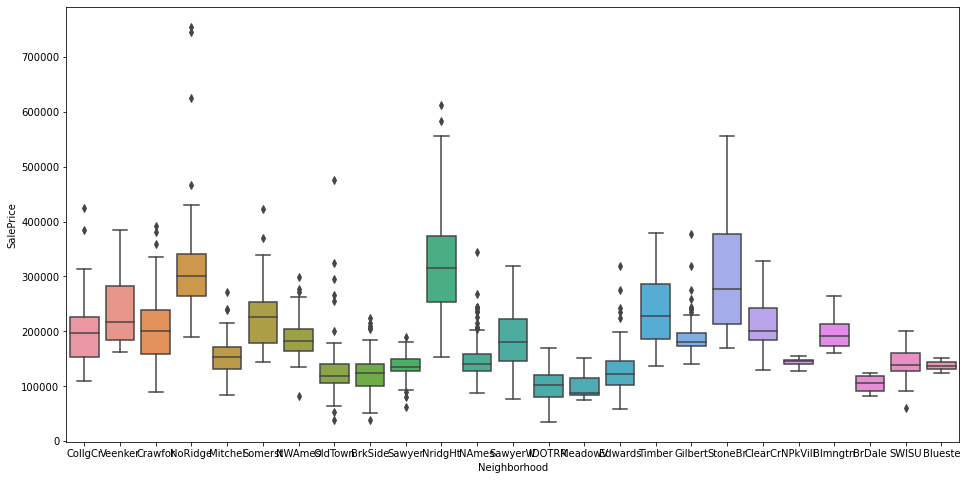

In [31]:
col = 'Neighborhood'
fig, axes = plt.subplots(figsize=(16, 8))
sns.boxplot(data=data[data.source == 'train'], y='SalePrice', x=col)

<AxesSubplot:xlabel='MSSubClass', ylabel='SalePrice'>

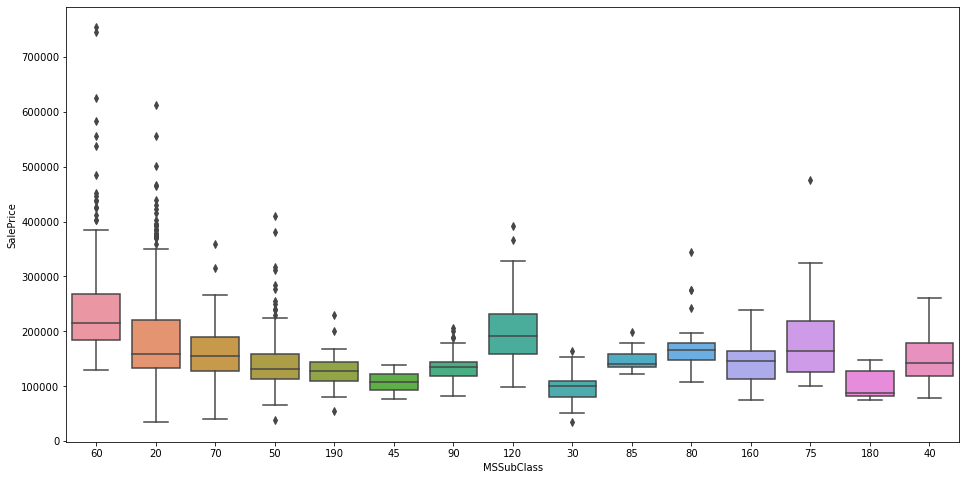

In [32]:
col = 'MSSubClass'
fig, axes = plt.subplots(figsize=(16, 8))
sns.boxplot(data=data[data.source == 'train'], y='SalePrice', x=col)

<AxesSubplot:xlabel='decade_YearBuilt', ylabel='SalePrice'>

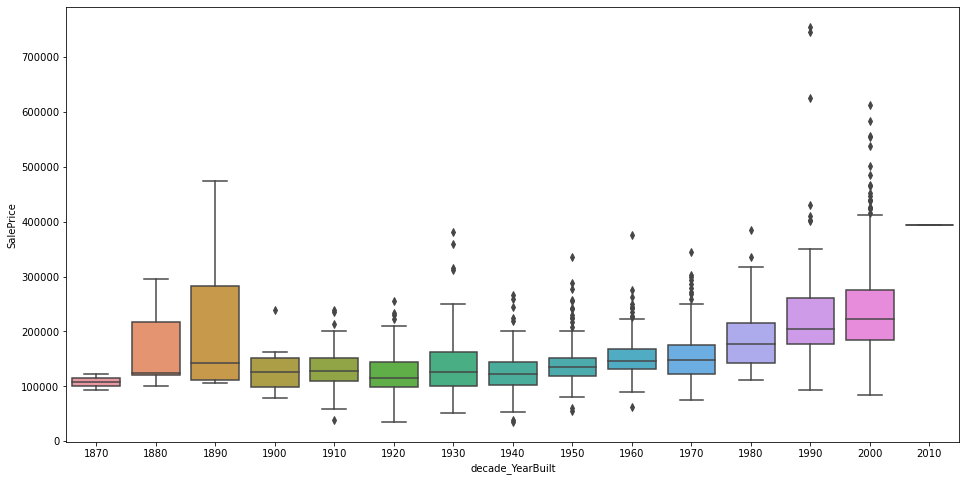

In [33]:
col = 'decade_YearBuilt'
fig, axes = plt.subplots(figsize=(16, 8))
sns.boxplot(data=data[data.source == 'train'].sort_values(by=col), y='SalePrice', x=col)

<AxesSubplot:xlabel='has_garage', ylabel='SalePrice'>

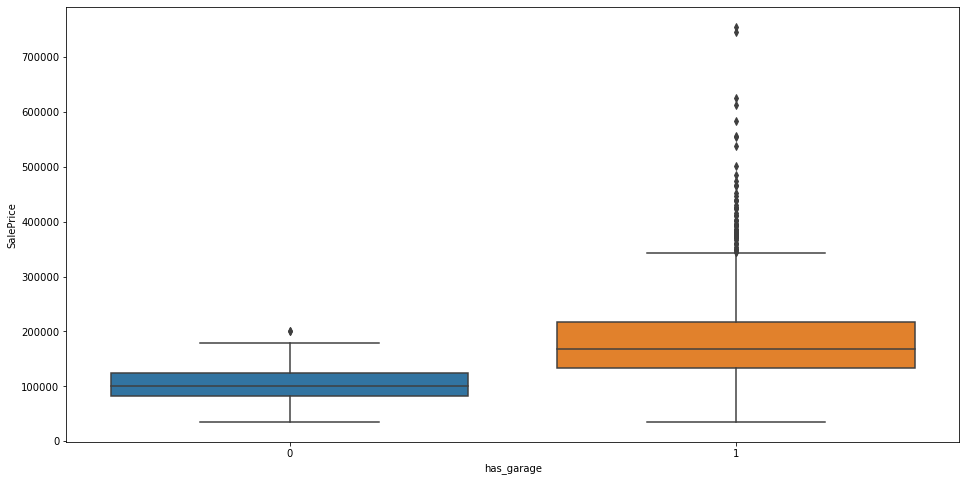

In [34]:
col = 'has_garage'
fig, axes = plt.subplots(figsize=(16, 8))
sns.boxplot(data=data[data.source == 'train'].sort_values(by=col), y='SalePrice', x=col)

<AxesSubplot:xlabel='total_num_bathrooms', ylabel='SalePrice'>

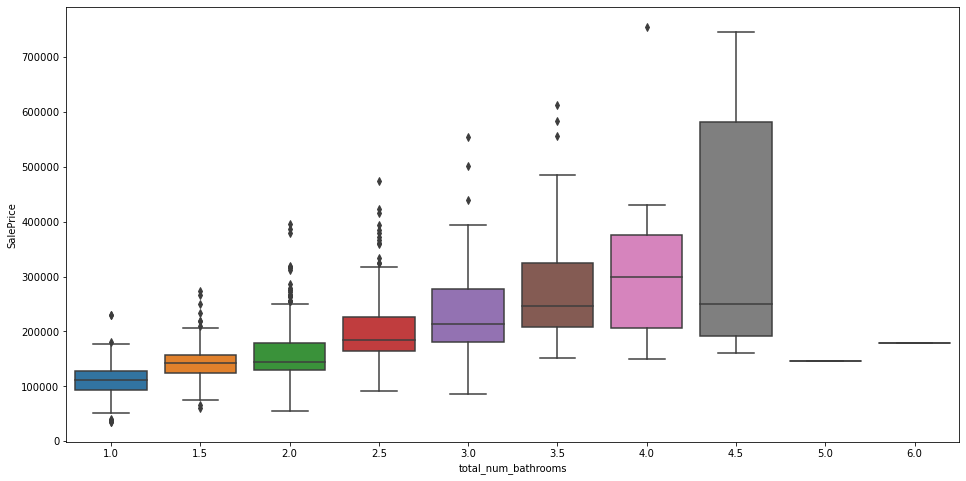

In [35]:
col = 'total_num_bathrooms'
fig, axes = plt.subplots(figsize=(16, 8))
sns.boxplot(data=data[data.source == 'train'].sort_values(by=col), y='SalePrice', x=col)

## Correlations

OverallQual           0.790982
total_sf              0.776337
log_total_sf          0.754251
GrLivArea             0.708624
log_GrLivArea         0.695147
                        ...   
has_porch_enclosed   -0.183374
age_garage           -0.261441
has_unf_garage       -0.410608
age_remodelling      -0.509079
age_building         -0.523350
Name: SalePrice, Length: 89, dtype: float64


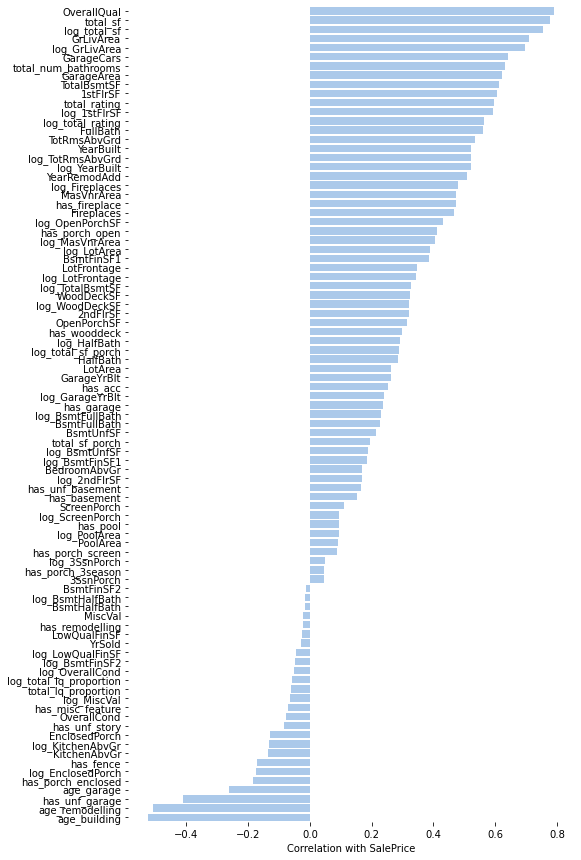

In [36]:
df = data.corr()['SalePrice'].sort_values(ascending=False).drop(index='SalePrice')
print(df)

# Initialize the matplotlib figure
fig, axes = plt.subplots(figsize=(8, 15))

# Load the example car crash dataset

# Plot the total crashes
sns.set_color_codes("pastel")
sns.barplot(y=df.index, x=df.values, color='b')

# Add a legend and informative axis label
axes.set(ylabel='',
         xlabel='Correlation with SalePrice')
sns.despine(left=True, bottom=True)

## Distribution

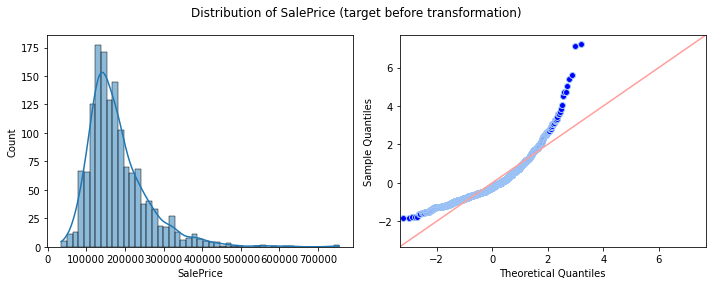

In [37]:
col = 'SalePrice'
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
sns.histplot(data=data, x=col, kde=True, ax=axes[0])
qqplot(data[col][data.source == 'train'], fit=True, line='45', ax=axes[1])
plt.suptitle(f'Distribution of {col} (target before transformation)')
fig.tight_layout()

In [38]:
col = 'log_SalePrice'
data[col] = np.log1p(data['SalePrice'])

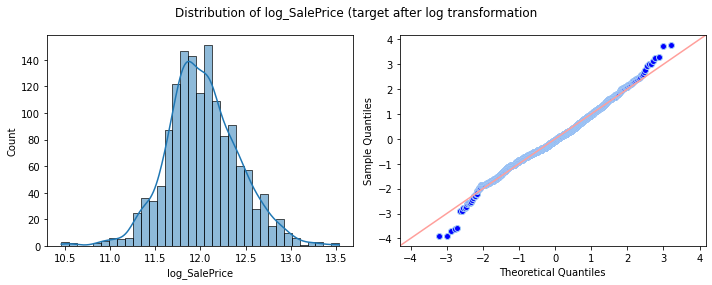

In [39]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
sns.histplot(data[col], kde=True, ax=axes[0])
qqplot(data[col][data.source == 'train'], fit=True, line='45', ax=axes[1])
plt.suptitle(f'Distribution of {col} (target after log transformation')
fig.tight_layout()

After log-transformation the target `SalePrice` shows more resemblance to the normal-distribution, although from the Q-Q plot we can see heavier tails.

# Modelling

## One-hot encoding

## Split data

In [40]:
# drop-first: keep only k-1 levels
data = pd.concat([pd.get_dummies(data=data.drop(columns=['source']), drop_first=True), data['source']], axis=1)

In [41]:
TARGET_NAME = 'log_SalePrice'
COLS_TO_DROP = ['source', 'SalePrice']
SEED = 42

# separate holdout and train set
test = data[data.source == 'test'].drop(columns=COLS_TO_DROP+[TARGET_NAME]).copy()
train = data[data.source == 'train'].drop(columns=COLS_TO_DROP).copy()

# separate target from train set
X = train.drop(columns=TARGET_NAME).copy()
y = train[TARGET_NAME].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=SEED)

print(f'Predictors (first 10):\n{X.columns.to_list()[:10]}')
print(f'\nTarget:\n{y.name}')
print(f'\nShape, train={X_train.shape}, test={X_test.shape}')

Predictors (first 10):
['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF']

Target:
log_SalePrice

Shape, train=(1022, 380), test=(438, 380)


## RandomForest

In [42]:
results_rf = {}

In [43]:
# baseline model
rf_baseline = RandomForestRegressor(random_state=SEED)
rf_baseline.fit(X_train, y_train)
y_pred = rf_baseline.predict(X_test)
# calculate rmse scores
rmse_rf_train = MSE(y_train,  rf_baseline.predict(X_train))**0.5
rmse_rf_test = MSE(y_test, y_pred)**0.5
rmse_rf_test

0.1327087378494688

### n_estimators

In [44]:
col = 'n_estimators'
param, train_err, test_err = [], [], []
for n_estimators in list(range(25, 401, 25)):
    # fit model and predict
    rf = RandomForestRegressor(n_estimators=n_estimators, random_state=SEED)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    # calculate rmse scores
    rmse_rf_train = MSE(y_train,  rf.predict(X_train))**0.5
    rmse_rf_test = MSE(y_test, y_pred)**0.5
    # save results
    param.append(n_estimators)
    train_err.append(rmse_rf_train)
    test_err.append(rmse_rf_test)
    print(f'{col}={n_estimators}, RMSE (test)={rmse_rf_test}')
results_rf[col] = pd.DataFrame({col: param, 'RMSE_train': train_err, 'RMSE_test': test_err})

n_estimators=25, RMSE (test)=0.13297536074071728
n_estimators=50, RMSE (test)=0.1341342208866491
n_estimators=75, RMSE (test)=0.1330188451663779
n_estimators=100, RMSE (test)=0.1327087378494688
n_estimators=125, RMSE (test)=0.13305700899570366
n_estimators=150, RMSE (test)=0.13295456452551363
n_estimators=175, RMSE (test)=0.13285324989022604
n_estimators=200, RMSE (test)=0.13307649873952107
n_estimators=225, RMSE (test)=0.13292812297212545
n_estimators=250, RMSE (test)=0.13314960421235889
n_estimators=275, RMSE (test)=0.13283074999779915
n_estimators=300, RMSE (test)=0.1326853426140994
n_estimators=325, RMSE (test)=0.13304224782457094
n_estimators=350, RMSE (test)=0.13298114538218797
n_estimators=375, RMSE (test)=0.13307428479853822
n_estimators=400, RMSE (test)=0.1331065095958533


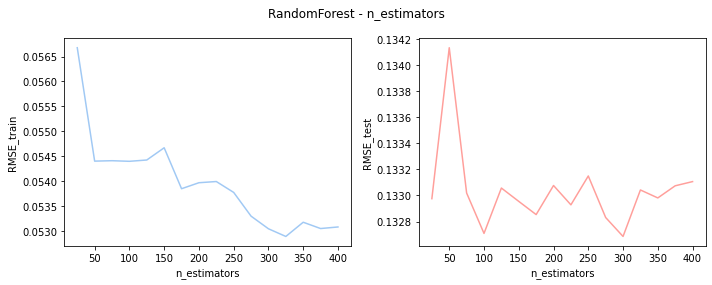

In [45]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
sns.lineplot(data=results_rf[col].set_index(col)['RMSE_train'], ax=axes[0], color='b')
sns.lineplot(data=results_rf[col].set_index(col)['RMSE_test'], ax=axes[1], color='r')
plt.suptitle(f'RandomForest - {col}')
fig.tight_layout()

### max_depth

In [46]:
col = 'max_depth'
param, train_err, test_err = [], [], []
for max_depth in list(range(1, 16)):
    # fit model and predict
    rf = RandomForestRegressor(max_depth=max_depth, random_state=SEED)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    # calculate rmse scores
    rmse_rf_train = MSE(y_train,  rf.predict(X_train))**0.5
    rmse_rf_test = MSE(y_test, y_pred)**0.5
    # save results
    param.append(max_depth)
    train_err.append(rmse_rf_train)
    test_err.append(rmse_rf_test)
    print(f'{col}={max_depth}, RMSE (test)={rmse_rf_test}')
results_rf[col] = pd.DataFrame({col: param, 'RMSE_train': train_err, 'RMSE_test': test_err})

max_depth=1, RMSE (test)=0.28066534376014407
max_depth=2, RMSE (test)=0.21269393250694726
max_depth=3, RMSE (test)=0.178130857228993
max_depth=4, RMSE (test)=0.1596798034430463
max_depth=5, RMSE (test)=0.14774846459264554
max_depth=6, RMSE (test)=0.14079587324590587
max_depth=7, RMSE (test)=0.13699411145135543
max_depth=8, RMSE (test)=0.13540736280517637
max_depth=9, RMSE (test)=0.1337118756999142
max_depth=10, RMSE (test)=0.13248946149022842
max_depth=11, RMSE (test)=0.13311242144095836
max_depth=12, RMSE (test)=0.13297081186183507
max_depth=13, RMSE (test)=0.132443981356621
max_depth=14, RMSE (test)=0.13269484322454927
max_depth=15, RMSE (test)=0.13283875783165305


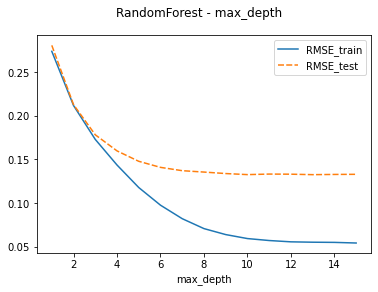

In [47]:
sns.lineplot(data=results_rf[col].set_index(col))
plt.suptitle(f'RandomForest - {col}')
fig.tight_layout()

### min_samples_split

In [48]:
col = 'min_samples_split'
param, train_err, test_err = [], [], []
for min_samples_split in np.arange(2, 11):
    # fit model and predict
    rf = RandomForestRegressor(min_samples_split=min_samples_split, random_state=SEED)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    # calculate rmse scores
    rmse_rf_train = MSE(y_train,  rf.predict(X_train))**0.5
    rmse_rf_test = MSE(y_test, y_pred)**0.5
    # save results
    param.append(min_samples_split)
    train_err.append(rmse_rf_train)
    test_err.append(rmse_rf_test)
    print(f'{col}={min_samples_split}, RMSE (test)={rmse_rf_test}')
results_rf[col] = pd.DataFrame({col: param, 'RMSE_train': train_err, 'RMSE_test': test_err})

min_samples_split=2, RMSE (test)=0.1327087378494688
min_samples_split=3, RMSE (test)=0.13226002422429395
min_samples_split=4, RMSE (test)=0.13198306376918348
min_samples_split=5, RMSE (test)=0.1330744068235823
min_samples_split=6, RMSE (test)=0.13257591536405333
min_samples_split=7, RMSE (test)=0.13204308840708856
min_samples_split=8, RMSE (test)=0.13300933591021633
min_samples_split=9, RMSE (test)=0.13321155914218002
min_samples_split=10, RMSE (test)=0.13340890308340475


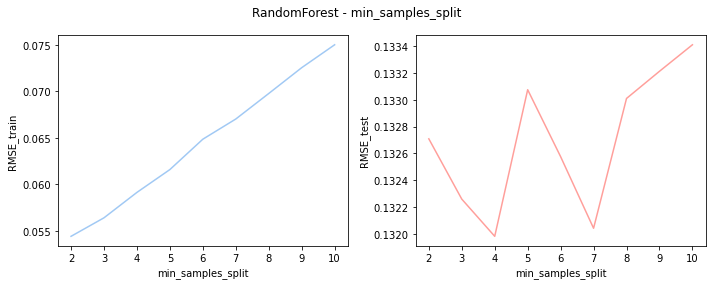

In [49]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
sns.lineplot(data=results_rf[col].set_index(col)['RMSE_train'], ax=axes[0], color='b')
sns.lineplot(data=results_rf[col].set_index(col)['RMSE_test'], ax=axes[1], color='r')
plt.suptitle(f'RandomForest - {col}')
fig.tight_layout()

### min_samples_leaf

In [50]:
col = 'min_samples_leaf'
param, train_err, test_err = [], [], []
for min_samples_split in np.arange(2, 11):
    # fit model and predict
    rf = RandomForestRegressor(min_samples_split=min_samples_split, random_state=SEED)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    # calculate rmse scores
    rmse_rf_train = MSE(y_train,  rf.predict(X_train))**0.5
    rmse_rf_test = MSE(y_test, y_pred)**0.5
    # save results
    param.append(min_samples_split)
    train_err.append(rmse_rf_train)
    test_err.append(rmse_rf_test)
    print(f'{col}={min_samples_split}, RMSE (test)={rmse_rf_test}')
results_rf[col] = pd.DataFrame({col: param, 'RMSE_train': train_err, 'RMSE_test': test_err})

min_samples_leaf=2, RMSE (test)=0.1327087378494688
min_samples_leaf=3, RMSE (test)=0.13226002422429395
min_samples_leaf=4, RMSE (test)=0.13198306376918348
min_samples_leaf=5, RMSE (test)=0.1330744068235823
min_samples_leaf=6, RMSE (test)=0.13257591536405333
min_samples_leaf=7, RMSE (test)=0.13204308840708856
min_samples_leaf=8, RMSE (test)=0.13300933591021633
min_samples_leaf=9, RMSE (test)=0.13321155914218002
min_samples_leaf=10, RMSE (test)=0.13340890308340475


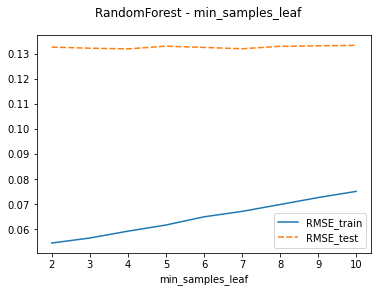

In [51]:
sns.lineplot(data=results_rf[col].set_index(col))
plt.suptitle(f'RandomForest - {col}')
fig.tight_layout()

### GridSearchCV

In [52]:
regressor_name = 'rndforest'
runtime_start = time()

# hyperparameter grid for the regressor
#param_distributions = {'n_estimators': np.arange(50, 1501, 50),
#                       'max_depth': range(1, 16),
#                       'min_samples_split': np.arange(2, 11),
#                       'min_samples_leaf': np.arange(2, 11)}
param_distributions = {'n_estimators': [50, 150, 250, 500, 1000, 1200],
                       'max_depth': [1, 2, 5, 10, 15],
                       'min_samples_split': [3, 5],
                       'min_samples_leaf': [3, 5]}

# setup for the search
#param_search = {'estimator': RandomForestRegressor(random_state=SEED),
#                'param_distributions': param_distributions,
#                'scoring': 'neg_mean_squared_error',
#                'cv': 5,
#                'n_iter': 50,
#                'n_jobs': -1,
#                'verbose': 2,
#                'random_state': SEED}
param_search = {'estimator': RandomForestRegressor(random_state=SEED),
                'param_grid': param_distributions,
                'scoring': 'neg_mean_squared_error',
                'cv': 5,
                'n_jobs': -1,
                'verbose': 2}

# model selection
search = GridSearchCV(**param_search)
search.fit(X_train, y_train)

# print results
runtime = time() - runtime_start
print(f'Runtime for {regressor_name}: {runtime:.1f} seconds.')
print(f'Best regressor:{search.best_estimator_}')
print(f'Best parameters:\n{search.best_params_}')

Fitting 5 folds for each of 120 candidates, totalling 600 fits
Runtime for rndforest: 1122.8 seconds.
Best regressor:RandomForestRegressor(max_depth=15, min_samples_leaf=3, min_samples_split=3,
                      n_estimators=500, random_state=42)
Best parameters:
{'max_depth': 15, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 500}


In [53]:
# fit the best model
rf_best = search.best_estimator_
rf_best.fit(X_train, y_train)
y_pred = rf_best.predict(X_test)
# calculate rmse scores
rmse_rf_train = MSE(y_train,  rf_best.predict(X_train))**0.5
rmse_rf_test = MSE(y_test, y_pred)**0.5

0.1341673062132548


<AxesSubplot:ylabel='Count'>

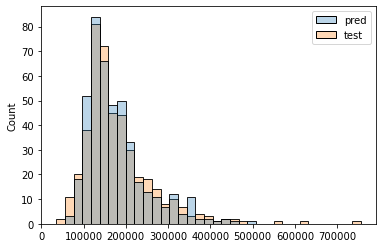

In [54]:
print(rmse_rf_test)
df_rf_best = pd.DataFrame({'pred': np.expm1(y_pred), 'test': np.expm1(y_test)})
sns.histplot(df_rf_best, alpha=0.3, bins=35)

## XGBoost

In [55]:
results_xgb = {}

In [56]:
# baseline model
# fit the best model
xgb_baseline = XGBRegressor(random_state=SEED)
xgb_baseline.fit(X_train, y_train)
y_pred = xgb_baseline.predict(X_test)
# calculate rmse scores
rmse_xgb_train = MSE(y_train,  xgb_baseline.predict(X_train))**0.5
rmse_xgb_test = MSE(y_test, y_pred)**0.5
rmse_xgb_test

0.1327087378494688

In [57]:
xgb_baseline

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

### n_estimators

In [58]:
col = 'n_estimators'
param, train_err, test_err = [], [], []
for n_estimators in list(range(25, 401, 25)):
    # fit model and predict
    rf = XGBRegressor(n_estimators=n_estimators, random_state=SEED)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    # calculate rmse scores
    rmse_rf_train = MSE(y_train,  rf.predict(X_train))**0.5
    rmse_rf_test = MSE(y_test, y_pred)**0.5
    # save results
    param.append(n_estimators)
    train_err.append(rmse_rf_train)
    test_err.append(rmse_rf_test)
    print(f'{col}={n_estimators}, RMSE (test)={rmse_rf_test}')
results_xgb[col] = pd.DataFrame({col: param, 'RMSE_train': train_err, 'RMSE_test': test_err})

n_estimators=25, RMSE (test)=0.14603113941383003
n_estimators=50, RMSE (test)=0.14618600533076384
n_estimators=75, RMSE (test)=0.14679448515613847
n_estimators=100, RMSE (test)=0.14693299386807707
n_estimators=125, RMSE (test)=0.1471237351440457
n_estimators=150, RMSE (test)=0.14711895032750769
n_estimators=175, RMSE (test)=0.147115968098942
n_estimators=200, RMSE (test)=0.14712346908100685
n_estimators=225, RMSE (test)=0.14712346908100685
n_estimators=250, RMSE (test)=0.14712346908100685
n_estimators=275, RMSE (test)=0.14712346908100685
n_estimators=300, RMSE (test)=0.14712346908100685
n_estimators=325, RMSE (test)=0.14712346908100685
n_estimators=350, RMSE (test)=0.14712346908100685
n_estimators=375, RMSE (test)=0.14712346908100685
n_estimators=400, RMSE (test)=0.14712346908100685


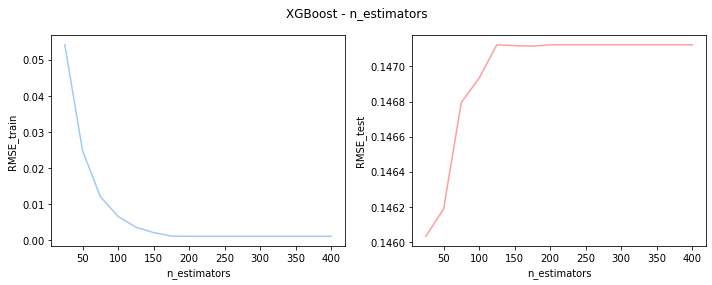

In [59]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
sns.lineplot(data=results_xgb[col].set_index(col)['RMSE_train'], ax=axes[0], color='b')
sns.lineplot(data=results_xgb[col].set_index(col)['RMSE_test'], ax=axes[1], color='r')
plt.suptitle(f'XGBoost - {col}')
fig.tight_layout()

### max_depth

In [60]:
col = 'max_depth'
param, train_err, test_err = [], [], []
for max_depth in list(range(1, 16)):
    # fit model and predict
    rf = XGBRegressor(max_depth=max_depth, random_state=SEED)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    # calculate rmse scores
    rmse_rf_train = MSE(y_train,  rf.predict(X_train))**0.5
    rmse_rf_test = MSE(y_test, y_pred)**0.5
    # save results
    param.append(max_depth)
    train_err.append(rmse_rf_train)
    test_err.append(rmse_rf_test)
    print(f'{col}={max_depth}, RMSE (test)={rmse_rf_test}')
results_xgb[col] = pd.DataFrame({col: param, 'RMSE_train': train_err, 'RMSE_test': test_err})

max_depth=1, RMSE (test)=0.13996937842935425
max_depth=2, RMSE (test)=0.13417997416884295
max_depth=3, RMSE (test)=0.14241696509959326
max_depth=4, RMSE (test)=0.14540957098679846
max_depth=5, RMSE (test)=0.15113429156714953
max_depth=6, RMSE (test)=0.14693299386807707
max_depth=7, RMSE (test)=0.14864939387793247
max_depth=8, RMSE (test)=0.14959883308451413
max_depth=9, RMSE (test)=0.1533513002593516
max_depth=10, RMSE (test)=0.15008572413030544
max_depth=11, RMSE (test)=0.15391973382869858
max_depth=12, RMSE (test)=0.15418391236063927
max_depth=13, RMSE (test)=0.15625690896834918
max_depth=14, RMSE (test)=0.15362788344495337
max_depth=15, RMSE (test)=0.15227624860135988


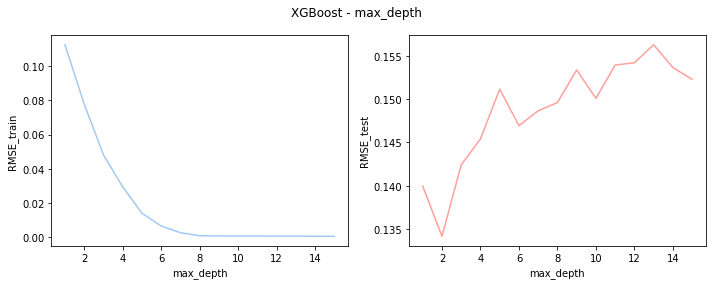

In [61]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
sns.lineplot(data=results_xgb[col].set_index(col)['RMSE_train'], ax=axes[0], color='b')
sns.lineplot(data=results_xgb[col].set_index(col)['RMSE_test'], ax=axes[1], color='r')
plt.suptitle(f'XGBoost - {col}')
fig.tight_layout()

### learning_rate (eta)

In [62]:
col = 'learning_rate'
param, train_err, test_err = [], [], []
for learning_rate in [0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]:
    # fit model and predict
    rf = XGBRegressor(learning_rate=learning_rate, random_state=SEED)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    # calculate rmse scores
    rmse_rf_train = MSE(y_train,  rf.predict(X_train))**0.5
    rmse_rf_test = MSE(y_test, y_pred)**0.5
    # save results
    param.append(learning_rate)
    train_err.append(rmse_rf_train)
    test_err.append(rmse_rf_test)
    print(f'{col}={learning_rate}, RMSE (test)={rmse_rf_test}')
results_xgb[col] = pd.DataFrame({col: param, 'RMSE_train': train_err, 'RMSE_test': test_err})

learning_rate=0.001, RMSE (test)=10.424278739359753
learning_rate=0.01, RMSE (test)=4.234598775659126
learning_rate=0.05, RMSE (test)=0.1552904082076895
learning_rate=0.1, RMSE (test)=0.1307110463737994
learning_rate=0.2, RMSE (test)=0.1373595883500123
learning_rate=0.3, RMSE (test)=0.14693299386807707
learning_rate=0.4, RMSE (test)=0.14564137636578095
learning_rate=0.5, RMSE (test)=0.15924857819130334


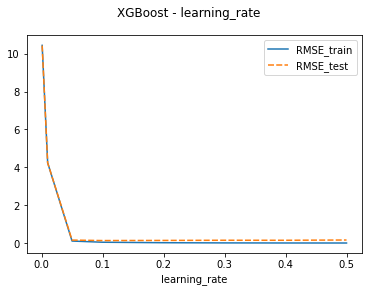

In [63]:
sns.lineplot(data=results_xgb[col].set_index(col))
plt.suptitle(f'XGBoost - {col}')
fig.tight_layout()

### gamma

In [64]:
col = 'gamma'
param, train_err, test_err = [], [], []
for gamma in [0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]:
    # fit model and predict
    rf = XGBRegressor(gamma=gamma, random_state=SEED)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    # calculate rmse scores
    rmse_rf_train = MSE(y_train,  rf.predict(X_train))**0.5
    rmse_rf_test = MSE(y_test, y_pred)**0.5
    # save results
    param.append(gamma)
    train_err.append(rmse_rf_train)
    test_err.append(rmse_rf_test)
    print(f'{col}={gamma}, RMSE (test)={rmse_rf_test}')
results_xgb[col] = pd.DataFrame({col: param, 'RMSE_train': train_err, 'RMSE_test': test_err})

gamma=0.001, RMSE (test)=0.14581241992577726
gamma=0.01, RMSE (test)=0.14451695103098858
gamma=0.05, RMSE (test)=0.14522152760504095
gamma=0.1, RMSE (test)=0.14709066383688296
gamma=0.2, RMSE (test)=0.14876774643886934
gamma=0.3, RMSE (test)=0.14927408412992502
gamma=0.4, RMSE (test)=0.15171093436681365
gamma=0.5, RMSE (test)=0.15543297790640795


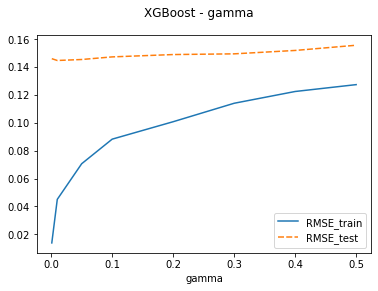

In [65]:
sns.lineplot(data=results_xgb[col].set_index(col))
plt.suptitle(f'XGBoost - {col}')
fig.tight_layout()

### GridSearchCV

In [66]:
regressor_name = 'xgboost'
runtime_start = time()

# hyperparameter grid for the regressor
param_distributions = {'n_estimators': [50, 150, 250, 500, 1000, 1200],
                       'max_depth': [1, 2, 5, 10, 15],
                       'learning_rate': [0.001, 0.01, 0.05],
                       'gamma': [0.001, 0.01, 0.05]}

# setup for the search
param_search = {'estimator': XGBRegressor(random_state=SEED),
                'param_grid': param_distributions,
                'scoring': 'neg_mean_squared_error',
                'cv': 5,
                'n_jobs': -1,
                'verbose': 2}

# model selection
search = GridSearchCV(**param_search)
search.fit(X_train, y_train)

# print results
runtime = time() - runtime_start
print(f'Runtime for {regressor_name}: {runtime:.1f} seconds.')
print(f'Best regressor:{search.best_estimator_}')
print(f'Best parameters:\n{search.best_params_}')

Fitting 5 folds for each of 270 candidates, totalling 1350 fits
Runtime for xgboost: 3146.8 seconds.
Best regressor:XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0.01, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.05, max_delta_step=0,
             max_depth=2, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)
Best parameters:
{'gamma': 0.01, 'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 1000}


In [67]:
# fit the best model
xgb_best = search.best_estimator_
xgb_best.fit(X_train, y_train)
y_pred = xgb_best.predict(X_test)
# calculate rmse scores
rmse_xgb_train = MSE(y_train,  xgb_best.predict(X_train))**0.5
rmse_xgb_test = MSE(y_test, y_pred)**0.5

0.1269681255856017


<AxesSubplot:ylabel='Count'>

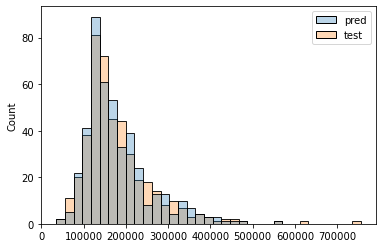

In [68]:
print(rmse_xgb_test)
df_xgb_best = pd.DataFrame({'pred': np.expm1(y_pred), 'test': np.expm1(y_test)})
sns.histplot(df_xgb_best, alpha=0.3, bins=35)

## Stacked model

In [69]:
results_stacked = {}

In [70]:
col = 'alpha'
param, train_err, test_err = [], [], []
for alpha in np.linspace(0.1, 1, 10):
    y_pred_train = alpha * rf_best.predict(X_train) + (1-alpha) * xgb_best.predict(X_train)
    y_pred = alpha * rf_best.predict(X_test) + (1-alpha) * xgb_best.predict(X_test)
    # calculate rmse scores
    rmse_stack_train = MSE(y_train,  y_pred_train)**0.5
    rmse_stack_test = MSE(y_test, y_pred)**0.5
    # save results
    param.append(alpha)
    train_err.append(rmse_stack_train)
    test_err.append(rmse_stack_test)
    print(f'{col}={alpha}, RMSE (test)={rmse_stack_test}')
results_stacked[col] = pd.DataFrame({col: param, 'RMSE_train': train_err, 'RMSE_test': test_err})

alpha=0.1, RMSE (test)=0.12572626138435947
alpha=0.2, RMSE (test)=0.12491913999144909
alpha=0.30000000000000004, RMSE (test)=0.12455526202498024
alpha=0.4, RMSE (test)=0.12463842526074355
alpha=0.5, RMSE (test)=0.12516778476894025
alpha=0.6, RMSE (test)=0.12613772566910184
alpha=0.7000000000000001, RMSE (test)=0.12753820305431682
alpha=0.8, RMSE (test)=0.12935520943085457
alpha=0.9, RMSE (test)=0.13157150792154423
alpha=1.0, RMSE (test)=0.1341673062132548


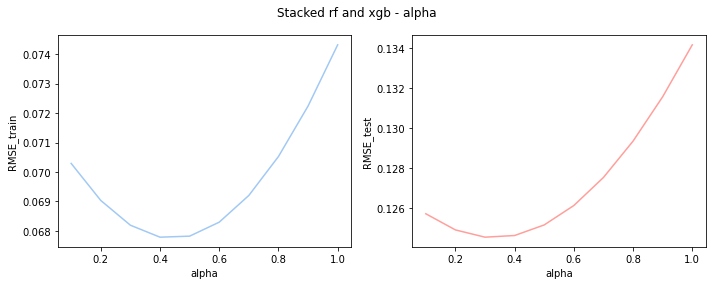

In [71]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
sns.lineplot(data=results_stacked[col].set_index(col)['RMSE_train'], ax=axes[0], color='b')
sns.lineplot(data=results_stacked[col].set_index(col)['RMSE_test'], ax=axes[1], color='r')
plt.suptitle(f'Stacked rf and xgb - {col}')
fig.tight_layout()

In [72]:
alpha = 0.3

# Submissions

In [73]:
def create_submission(model):
    return pd.DataFrame({'Id': test.index.values, 'SalePrice': np.expm1(model.predict(test))})

In [74]:
# example of the layout
create_submission(model=rf_best)

,Id,SalePrice
0,1461,124584.947112
1,1462,154012.921159
2,1463,171243.712816
3,1464,184410.183317
4,1465,202109.494399
...,...,...
1454,2915,93322.336203
1455,2916,90890.528274
1456,2917,160334.934637
1457,2918,116077.649351


In [75]:
for name, model in {'randomforest': rf_best, 'xgboost': xgb_best}.items():
    print(model)
    df_submission = create_submission(model=model)
    df_submission.to_csv(f'result/{name}.csv', index=False)
    print(df_submission.head(3), '\n' + '*'*75 + '\n')

RandomForestRegressor(max_depth=15, min_samples_leaf=3, min_samples_split=3,
                      n_estimators=500, random_state=42)
     Id      SalePrice
0  1461  124584.947112
1  1462  154012.921159
2  1463  171243.712816 
***************************************************************************

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0.01, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.05, max_delta_step=0,
             max_depth=2, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)
     Id      SalePrice
0  1461  118403.031250
1  1462  154606.609375


In [76]:
y_pred = alpha * rf_best.predict(test) + (1-alpha) * xgb_best.predict(test)
df_submission = pd.DataFrame({'Id': test.index.values,
                              'SalePrice': np.expm1(y_pred)})

In [77]:
df_submission.to_csv(f'result/stacked.csv', index=False)